In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from concurrent.futures import ProcessPoolExecutor
import pickle



In [18]:
%matplotlib inline

In [19]:
# Function to perform Augmented Dickey-Fuller test
def adf_test(series, signif=0.05):
    dftest = adfuller(series, autolag='AIC')
    #print('dftest  ',dftest)
    #dftest[1] is p-value 
    p_value = dftest[1]
    return p_value <= signif  # Returns True if p-value is less than significance level

In [21]:
def check_timestamp_irreg(df_input):
    time_diff = df_input.index.to_series().diff()
    print(time_diff)
    max_diff = time_diff.max()
    min_diff = time_diff.min()
    mean_diff = time_diff.mean()
    median_diff = time_diff.median()
    
    # Print the results
    print(f"Max difference: {max_diff}")
    print(f"Min difference: {min_diff}")
    print(f"Mean difference: {mean_diff}")
    print(f"Median difference: {median_diff}")
    return time_diff

In [22]:
def resampling_interpolation(df_input):
    # Step 4: Resample the data to your desired frequency; L is millisecond
    df_resampled = df_input.resample('20L').mean()  # 'S' stands for second intervals
    
    # Step 5: Interpolate missing values if needed
    df_resampled = df_resampled.interpolate(method='linear')
    
    # Print the resampled DataFrame
    #print(df_resampled)
    return df_resampled

In [23]:
def data_normalization(df_input,mode,scaler):
    if mode=='fit':
        df_scaled = pd.DataFrame(scaler.fit_transform(df_input), columns=df_input.columns, index=df_input.index)
    elif mode=='transform':
        df_scaled = pd.DataFrame(scaler.transform(df_input), columns=df_input.columns, index=df_input.index)
    return df_scaled,scaler

In [24]:
def preprocess_df(df,feature):
    #print(df.head())
    
    df['timestamp'] = df['timestamp'] / 1e9  # Convert from nanoseconds to seconds
    #Convert to a pandas datetime object
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    #Set the 'timestamp' column as the index
    df.set_index('timestamp', inplace=True)
    # Plot the features for visualization
    df[feature].plot(subplots=True, figsize=(10, 12))
    plt.legend(loc='upper right')

    plt.show()

    df_diff = df.copy()

    for col in feature:
        print('feature  ',col)
        #print('cc *******      ',adf_test(df[col]))
        if not adf_test(df[col]):
            print(f"{col} is not stationary, differencing...")
            df_diff[col] = df[col].diff().dropna()
        else:
            print("======== stationary =======")
    # Drop the first rows with NaN values after differencing
    df_diff.dropna(inplace=True)

    time_diff = check_timestamp_irreg(df)
    time_diff = time_diff.dropna()
    print(time_diff)
    plt.figure(figsize=(10, 5))
    time_diff.plot(kind='bar')
    plt.ylabel('Time Difference')
    plt.title('Time Gaps Between Consecutive Timestamps')
    plt.show()
    
    data_resampl=resampling_interpolation(df)
    check_timestamp_irreg(data_resampl)
    return data_resampl

In [95]:
def random_sample_imputation(data, drop_fraction=0.1):
    # Randomly drop some data points
    num_drop = int(len(data) * drop_fraction)
    drop_indices = np.random.choice(data.index, num_drop, replace=False)
    resampled_data = data.drop(drop_indices)
    
    # Perform random sample imputation
    for idx in drop_indices:
        # Randomly select a value from the remaining data
        random_value = resampled_data.sample(n=1).values[0]
        # Replace the missing value with the random sample
        data.loc[idx] = random_value
    
    return data

In [34]:
# Fit the VAR model using success data
def check_optimal_lag(df_train_norm,feature,maxlags = 50):
    
    # Initialize lists to store information criteria values
    aic_vals = []
    bic_vals = []
    fpe_vals = []
    hqic_vals = []
    
    # Fit VAR model for each lag and collect the information criteria
    for lag in range(1, maxlags + 1):
        model = VAR(df_train_norm[feature])
        result = model.fit(lag)
        #print('result ',result)
        # Append the AIC, BIC, FPE, and HQIC values for each lag
        aic_vals.append(result.aic)
        bic_vals.append(result.bic)
        fpe_vals.append(result.fpe)
        hqic_vals.append(result.hqic)
    
    # Create a list of lag values
    lags = list(range(1, maxlags + 1))
    
    # Plot the information criteria
    plt.figure(1,figsize=(10, 6))
    plt.plot(lags, aic_vals, label='AIC')
    plt.plot(lags, bic_vals, label='BIC')
    plt.plot(lags, hqic_vals, label='HQIC')
    
    # Add labels and title
    #FIG1
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    plt.xlim(left=0)
    plt.xlabel('Lag Order')
    plt.ylabel('Information Criterion')
    plt.title('Lag Order Selection by Information Criteria')
    plt.legend()
    plt.grid(True)

    plt.figure(2,figsize=(10, 6))
    plt.plot(lags, fpe_vals, label='FPE')
    
    # Add labels and title
    #FIG2
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    plt.xlim(left=0)
    plt.xlabel('Lag Order')
    plt.ylabel('Information Criterion')
    plt.title('Lag Order Selection by Information Criteria')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [143]:
def plot_residual(feature,df_test_normalized,df_test_resample,forecast_df,residuals=None):
    fig, axes = plt.subplots(len(feature), 1, figsize=(10, 30))
    for i, col in enumerate(feature):
        axes[i].plot(df_test_normalized.index, df_test_normalized[col])
        axes[i].plot(forecast_df.index, forecast_df[col], linestyle='--')

        # Highlight failure regions in residuals plot
        for j, flag in df_test_resample.iterrows():
            if flag['success'] == 0:
                axes[i].axvspan(j, j + pd.Timedelta(20, unit='L'), color='red', alpha=0.3)
        axes[i].set_title(f'Comparison for {col}')
    
    plt.tight_layout()
    plt.show() 

    if residuals:
        # Plot residuals (should indicate anomalies where the forecast deviates from actual values) with highlighted regions
        fig, axes = plt.subplots(len(feature), 1, figsize=(10, 30))
        for i, col in enumerate(feature):
            axes[i].plot(residuals.index, residuals[col])
            
            # Highlight failure regions in residuals plot
            for j, flag in df_test_resample.iterrows():
                if flag['success'] == 0:
                    axes[i].axvspan(j, j + pd.Timedelta(20, unit='L'), color='red', alpha=0.3)
            
            axes[i].set_title(f'Residuals for {col}')

        
        plt.tight_layout()
        plt.show()

In [97]:
def plot_epochs_vs_loss(data, maxlags=10,max_epochs=5):
    losses = []
    best_loss = float('inf')
    best_model = None
    
    for epoch in range(1, max_epochs + 1):
        resampled_data = random_sample_imputation(data, drop_fraction=0.1)
        model = VAR(resampled_data)
        results = model.fit(maxlags)
        # Calculate loss (sum of squared errors)
        predicted = results.fittedvalues
        actual = resampled_data.iloc[results.k_ar:]
        loss = ((predicted - actual) ** 2).sum().sum()
        losses.append(loss)

        # Update best model if current loss is lower
        if loss < best_loss:
            best_loss = loss
            best_model = results

    # Plot losses over epochs
    plt.plot(range(1, max_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Generalization Loss')
    plt.title('Epochs vs Generalization Loss')
    plt.show()

    return best_model

In [155]:
def predict_with_var_model(best_model, lag_order, test_data):
    # Determine the number of lags used in the model
    lag_order = best_model.k_ar
    
    # Prepare input for forecasting by taking the last 'lag_order' observations from training data
    
    # Forecasting using the best model
    predictions = best_model.forecast(y=test_data.values[:lag_order], steps=len(test_data))
    
    # Convert predictions to DataFrame for easier comparison
    predicted_df = pd.DataFrame(predictions, index=test_data.index, columns=test_data.columns)
    
    return predicted_df

In [11]:
def calculate_residual(feature,df_train_normalized,df_test_normalized,df_test_resampl,lag_order_aic):
    # model = VAR(df_train_normalized[feature])
    # var_model_success = model.fit(lag_order_aic)
    
    resampled_data = random_resample(df_train_normalized[feature], drop_fraction=0.1)
    model = VAR(resampled_data)
    var_model_success = model.fit(lag_order_aic)

    failure_forecast = var_model_success.forecast(df_test_normalized[feature].values[-lag_order_aic:], steps=len(df_test_normalized[feature]))
    forecast_df = pd.DataFrame(failure_forecast, index=df_test_normalized[feature].index, columns=feature)
    residuals = abs(df_test_normalized[feature] - forecast_df)
    # print('res  ',residuals)
    # plot_residual(df_test_normalized,forecast_df,residuals)
    # plot_residual2(df_test_normalized,forecast_df,residuals)
    plot_residual(feature,df_test_normalized,df_test_resampl,forecast_df,residuals)
    return residuals,var_model_success

In [12]:
def plot_sum_abs_residual(feature,df_test_resample,residuals):
    fig, axes = plt.subplots(len(feature), 1, figsize=(10, 30))
    for i, col in enumerate(feature):
        axes[i].plot(residuals.index, residuals[col])

        # Highlight failure regions in residuals plot
        for j, flag in df_test_resample.iterrows():
            #print('j   ',j)
            if flag['success'] == 0:
                axes[i].axvspan(j, j + pd.Timedelta(30, unit='L'), color='red', alpha=0.3)
        axes[i].set_title(f'Sum_abs_residual for {col}')
    
    plt.tight_layout()
    plt.show() 

In [13]:
def sum_abs_residual(feature,df_test_resample,residual_df, horizon=5):
    """
    Calculate the sum of absolute residuals over a specified horizon for each column in the DataFrame.
    
    Parameters:
    - residual_df: pandas DataFrame containing residual values (each column represents a different feature).
    - horizon: Lookback window to calculate the sum of absolute residuals.
    
    Returns:
    - A DataFrame with the sum of absolute residuals for each column.
    """
    sum_abs_residuals_df = pd.DataFrame()

    # Loop through each column in the DataFrame
    for col in residual_df.columns:
        residual = residual_df[col].values  # Convert column to numpy array
        
        # Efficient sliding window calculation using NumPy's stride_tricks
        sliding_windows = np.lib.stride_tricks.sliding_window_view(residual, window_shape=horizon)
        sum_abs_residuals = np.sum(np.abs(sliding_windows), axis=1)
        
        # Adjust index: shift the index so the sum corresponds to the current time (t)
        valid_index = residual_df.index[horizon-1:]  # Start from the current time t
        
        # Store the result for this column in the DataFrame with the adjusted index
        sum_abs_residuals_df[col] = pd.Series(sum_abs_residuals, index=valid_index)
    plot_sum_abs_residual(feature,df_test_resample,sum_abs_residuals_df)
    return sum_abs_residuals_df

In [152]:
def main_calculation(feature,two_file,test_file,train_file=None):
    if two_file:
        df_test = pd.read_csv(test_file)
        df_train = pd.read_csv(train_file)        
    else:
        df_test = pd.read_csv(test_file)
        df_train = df_test[df_test['success'] == 1]
    
    # df_test.to_excel('df_test.xlsx')
    # df_train.to_excel('df_train.xlsx')
    # print('test  ',df_test)
    # print('train   ',df_train)

    df_train_resampl=preprocess_df(df_train,feature)
    df_test_resampl=preprocess_df(df_test,feature)
    
    # df_test_resampl.to_excel('df_test_resampl.xlsx')
    # df_train_resampl.to_excel('df_train_resampl.xlsx')
    scaler = StandardScaler()

    #scaler = MinMaxScaler(feature_range=(-1, 1))
    df_train_norm,scaler=data_normalization(df_train_resampl,'fit',scaler)
    df_test_norm,scaler=data_normalization(df_test_resampl,'transform',scaler)
    
    # df_train_norm.to_excel('df_train_norm.xlsx')
    # df_test_norm.to_excel('df_test_norm.xlsx')
    
    df_test_norm['success'] = df_test_norm['success'].apply(lambda x: 1 if x > 0.5 else 0)
    check_optimal_lag(df_train_norm,feature,50)
    return df_train_norm,df_test_norm,df_test_resampl

    #return None,None,None

In [15]:
def plot_total_residual(feature,df_test_resample,combined_column):
    plt.figure(figsize=(10, 6))
    col='combined_normalized'
    plt.plot(combined_column.index, combined_column[col])
    print(combined_column[col])
    # Highlight failure regions
    # for i, flag in df_test_resample.iterrows():
    #     if flag['success'] == 0:
    #         plt.axvspan(i, i + pd.Timedelta(30, unit='L'), color='red', alpha=0.3)  # Highlight failure cases
    
    plt.show()

In [16]:
def normalize_and_combine(feature,df_test_resample,df_residuals):
    scaler = MinMaxScaler()
    normalized_values_list = []

    # Normalize each column independently
    for col in df_residuals.columns:
        normalized_col = scaler.fit_transform(df_residuals[[col]])  # Normalize each column separately
        normalized_values_list.append(pd.Series(normalized_col.flatten(), index=df_residuals.index))
    
    # Combine all normalized columns into one column
    combined_column = pd.concat(normalized_values_list).to_frame('combined_normalized')
    plot_total_residual(feature,df_test_resample,combined_column)
    return combined_column

# Granger Causality Test

In [53]:
#Granger causality test to determine variable relevance
#https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2
def granger_causality_matrix(df, feature, maxlag=10):
    result = pd.DataFrame(np.zeros((len(feature), len(feature))), columns=feature, index=feature)
    for c in result.columns:
        for r in result.index:
            if r != c:  # Avoid testing a variable against itself
                test_result = grangercausalitytests(df[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test[0]['ssr_chi2test'][1], 4) for test in test_result.values()]
                min_p_value = np.min(p_values)
                result.loc[r, c] = min_p_value
    result.columns = [var + '_x' for var in feature]
    result.index = [var + '_y' for var in feature]
    return result

test            timestamp  laplacian_variance  blur_bool   entropy  brightness  \
0     1.413395e+18          278.679521      False  7.306545  101.761672   
1     1.413395e+18          277.734216      False  7.310415  101.776762   
2     1.413395e+18          277.213306      False  7.309099  101.740750   
3     1.413395e+18          276.337646      False  7.307611  101.563567   
4     1.413395e+18          276.461357      False  7.311522  101.795869   
...            ...                 ...        ...       ...         ...   
1888  1.413395e+18          829.731050      False  7.562529  155.480416   
1889  1.413395e+18          851.846551      False  7.562492  155.461012   
1890  1.413395e+18          808.283754      False  7.391374  166.161807   
1891  1.413395e+18          837.568800      False  7.494445  160.416982   
1892  1.413395e+18          843.763639      False  7.498795  160.244725   

       contrast  brightness_contrast_ratio  disparity_mean  disparity_var  \
0     85.364682

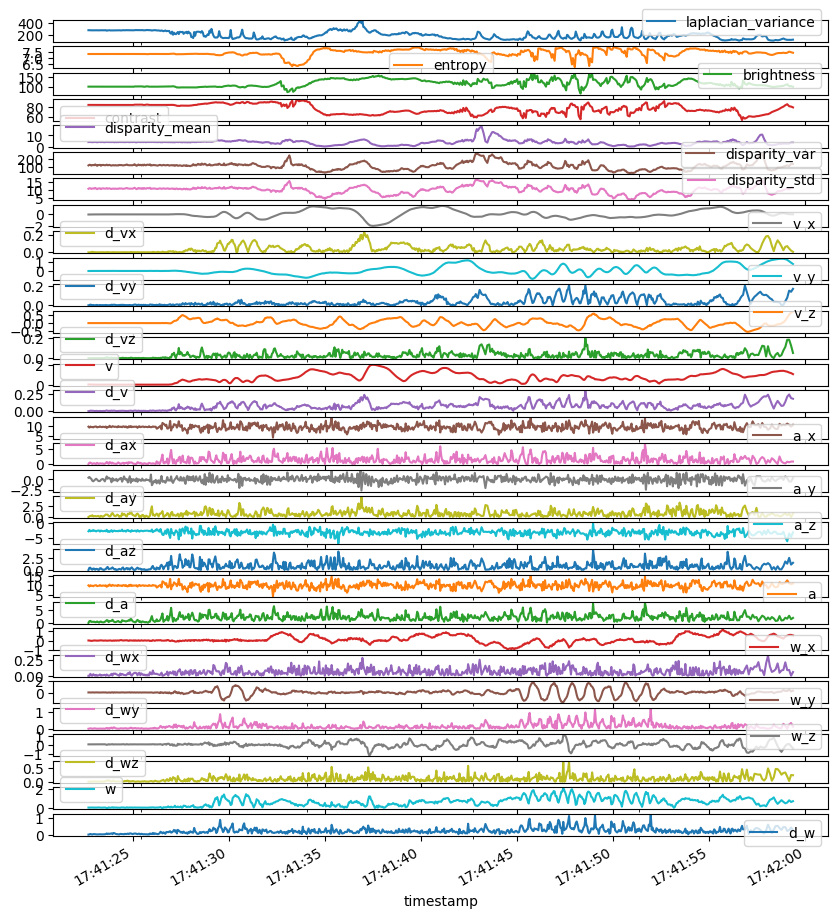

feature   laplacian_variance
laplacian_variance is not stationary, differencing...
feature   entropy
======== stationary =======
feature   brightness
brightness is not stationary, differencing...
feature   contrast
contrast is not stationary, differencing...
feature   disparity_mean
======== stationary =======
feature   disparity_var
======== stationary =======
feature   disparity_std
======== stationary =======
feature   v_x
======== stationary =======
feature   d_vx
======== stationary =======
feature   v_y
======== stationary =======
feature   d_vy
d_vy is not stationary, differencing...
feature   v_z
======== stationary =======
feature   d_vz
======== stationary =======
feature   v
======== stationary =======
feature   d_v
======== stationary =======
feature   a_x
======== stationary =======
feature   d_ax
======== stationary =======
feature   a_y
======== stationary =======
feature   d_ay
======== stationary =======
feature   a_z
======== stationary =======
feature   d_az
========

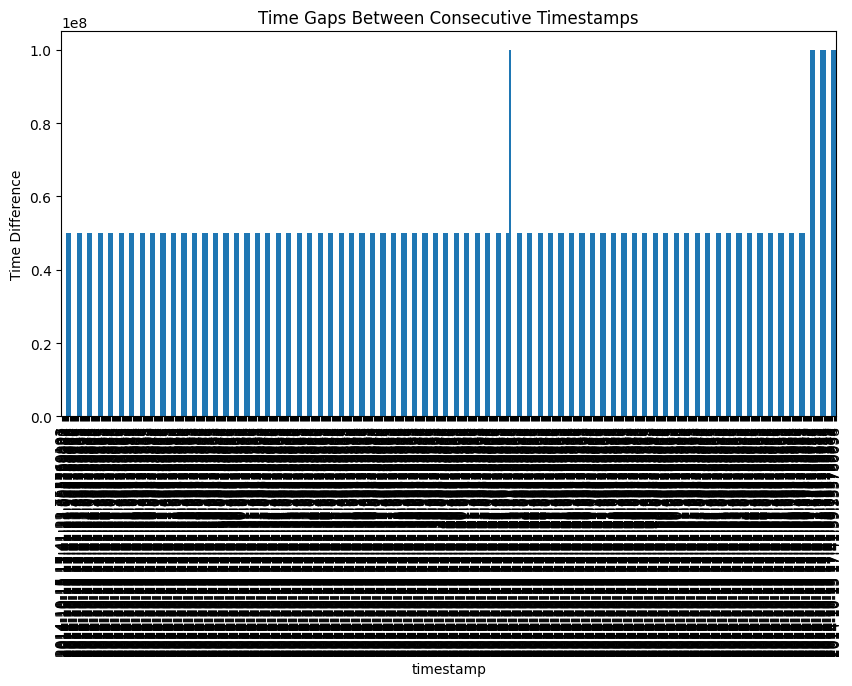

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\1408553103.py:3: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_input.resample('20L').mean()  # 'S' stands for second intervals


timestamp
2014-10-15 17:41:22.700                      NaT
2014-10-15 17:41:22.720   0 days 00:00:00.020000
2014-10-15 17:41:22.740   0 days 00:00:00.020000
2014-10-15 17:41:22.760   0 days 00:00:00.020000
2014-10-15 17:41:22.780   0 days 00:00:00.020000
                                   ...          
2014-10-15 17:41:59.260   0 days 00:00:00.020000
2014-10-15 17:41:59.280   0 days 00:00:00.020000
2014-10-15 17:41:59.300   0 days 00:00:00.020000
2014-10-15 17:41:59.320   0 days 00:00:00.020000
2014-10-15 17:41:59.340   0 days 00:00:00.020000
Freq: 20ms, Name: timestamp, Length: 1833, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.020000
Min difference: 0 days 00:00:00.020000
Mean difference: 0 days 00:00:00.020000
Median difference: 0 days 00:00:00.020000


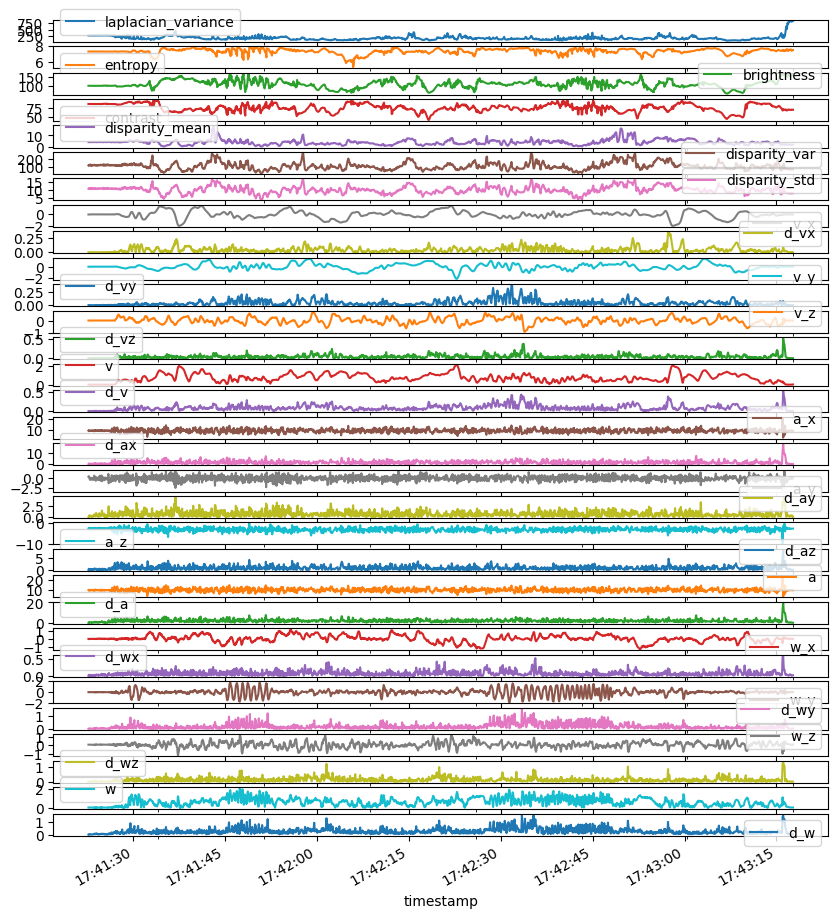

feature   laplacian_variance
laplacian_variance is not stationary, differencing...
feature   entropy
======== stationary =======
feature   brightness
======== stationary =======
feature   contrast
======== stationary =======
feature   disparity_mean
======== stationary =======
feature   disparity_var
======== stationary =======
feature   disparity_std
======== stationary =======
feature   v_x
======== stationary =======
feature   d_vx
======== stationary =======
feature   v_y
======== stationary =======
feature   d_vy
======== stationary =======
feature   v_z
======== stationary =======
feature   d_vz
======== stationary =======
feature   v
======== stationary =======
feature   d_v
======== stationary =======
feature   a_x
======== stationary =======
feature   d_ax
======== stationary =======
feature   a_y
======== stationary =======
feature   d_ay
======== stationary =======
feature   a_z
======== stationary =======
feature   d_az
======== stationary =======
feature   a
======== stati

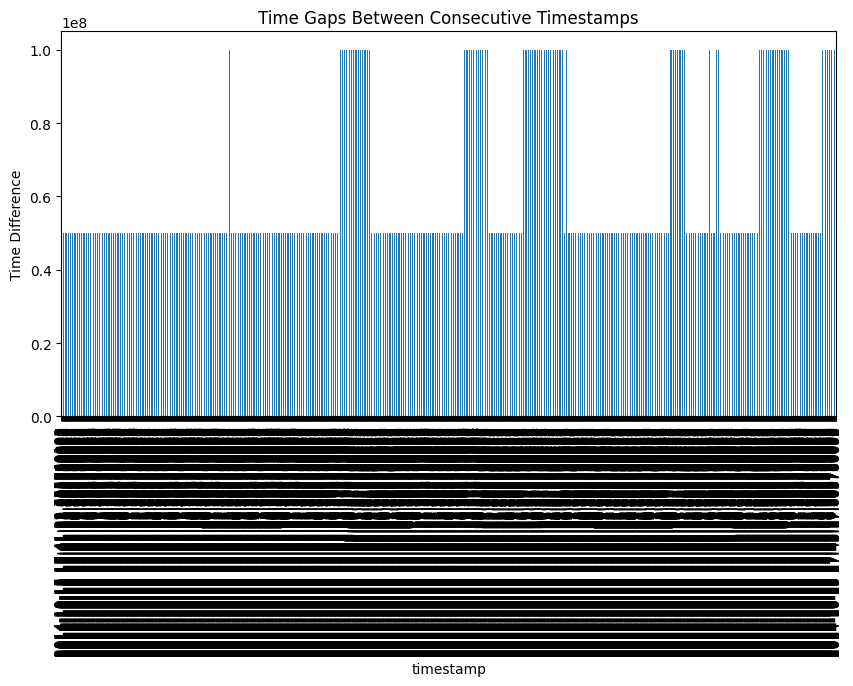

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\1408553103.py:3: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_input.resample('20L').mean()  # 'S' stands for second intervals


timestamp
2014-10-15 17:41:22.700                      NaT
2014-10-15 17:41:22.720   0 days 00:00:00.020000
2014-10-15 17:41:22.740   0 days 00:00:00.020000
2014-10-15 17:41:22.760   0 days 00:00:00.020000
2014-10-15 17:41:22.780   0 days 00:00:00.020000
                                   ...          
2014-10-15 17:43:17.620   0 days 00:00:00.020000
2014-10-15 17:43:17.640   0 days 00:00:00.020000
2014-10-15 17:43:17.660   0 days 00:00:00.020000
2014-10-15 17:43:17.680   0 days 00:00:00.020000
2014-10-15 17:43:17.700   0 days 00:00:00.020000
Freq: 20ms, Name: timestamp, Length: 5751, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.020000
Min difference: 0 days 00:00:00.020000
Mean difference: 0 days 00:00:00.020000
Median difference: 0 days 00:00:00.020000


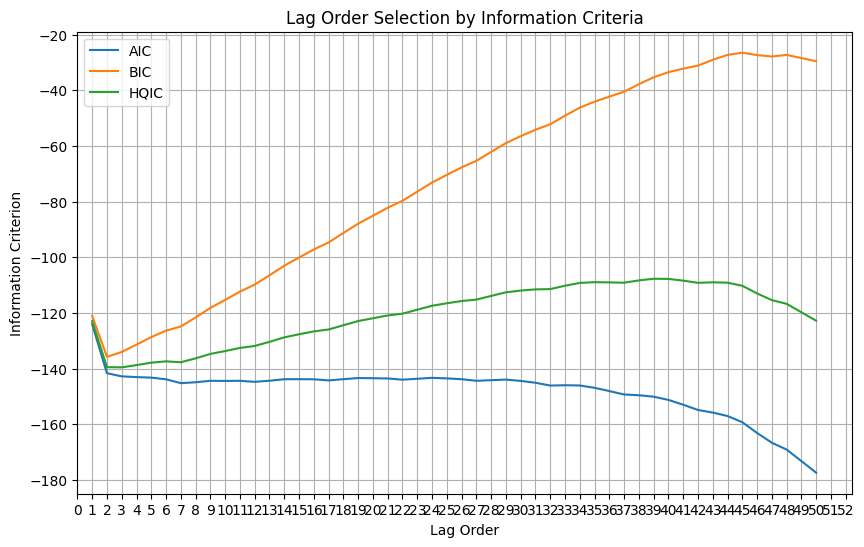

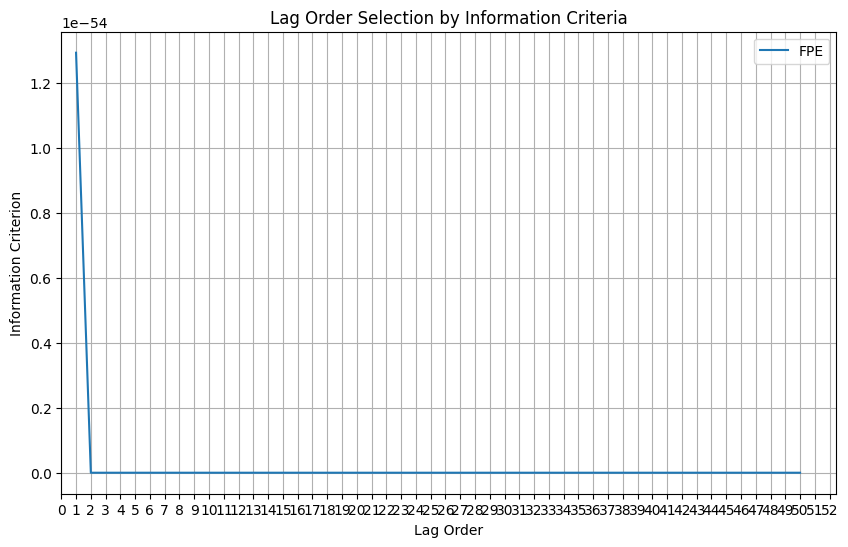

In [35]:
selected_features=['laplacian_variance', 'entropy', 'brightness', 'contrast','disparity_mean','disparity_var','disparity_std','v_x','d_vx','v_y','d_vy','v_z','d_vz','v','d_v','a_x','d_ax','a_y','d_ay','a_z','d_az','a','d_a','w_x','d_wx','w_y','d_wy','w_z','d_wz','w','d_w']
df_train,df_test,df_test_res=main_calculation(selected_features,True,'features_v203_openvslam_test.csv','features_v203_openvslam_train.csv')

In [56]:
granger_result=granger_causality_matrix(df_train,selected_features)
granger_result.to_excel('output.xlsx', index=True)


c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  

# Analysis: Selected Feature 1

test            timestamp  laplacian_variance  blur_bool   entropy  brightness  \
0     1.413395e+18          278.679521      False  7.306545  101.761672   
1     1.413395e+18          277.734216      False  7.310415  101.776762   
2     1.413395e+18          277.213306      False  7.309099  101.740750   
3     1.413395e+18          276.337646      False  7.307611  101.563567   
4     1.413395e+18          276.461357      False  7.311522  101.795869   
...            ...                 ...        ...       ...         ...   
1888  1.413395e+18          829.731050      False  7.562529  155.480416   
1889  1.413395e+18          851.846551      False  7.562492  155.461012   
1890  1.413395e+18          808.283754      False  7.391374  166.161807   
1891  1.413395e+18          837.568800      False  7.494445  160.416982   
1892  1.413395e+18          843.763639      False  7.498795  160.244725   

       contrast  brightness_contrast_ratio  disparity_mean  disparity_var  \
0     85.364682

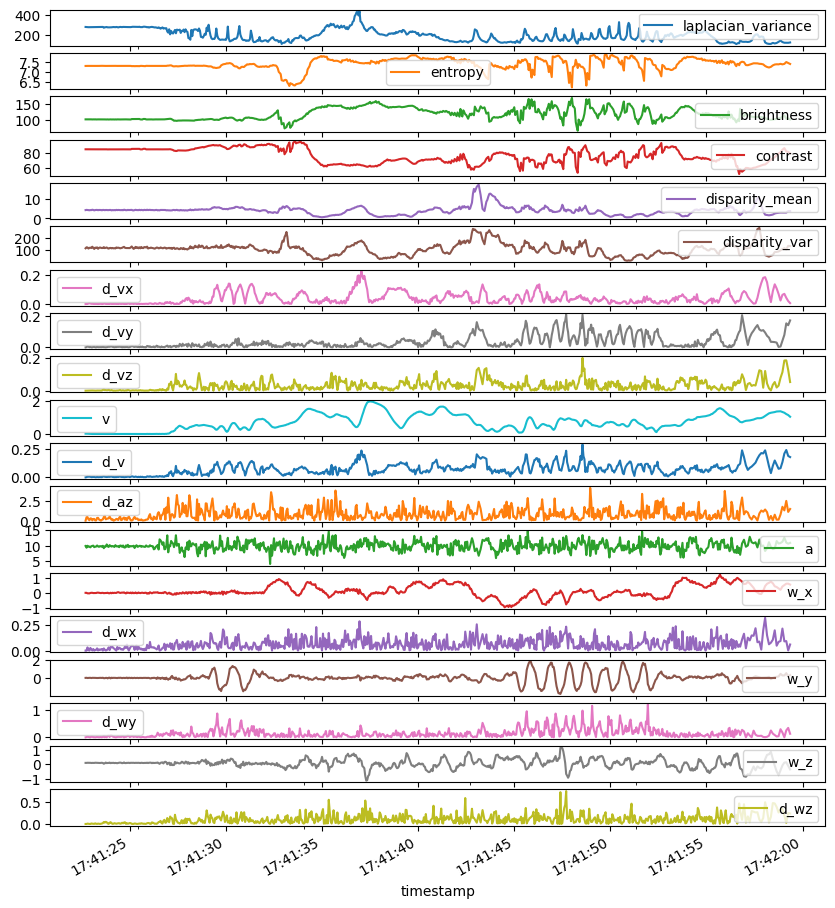

feature   laplacian_variance
laplacian_variance is not stationary, differencing...
feature   entropy
======== stationary =======
feature   brightness
brightness is not stationary, differencing...
feature   contrast
contrast is not stationary, differencing...
feature   disparity_mean
======== stationary =======
feature   disparity_var
======== stationary =======
feature   d_vx
======== stationary =======
feature   d_vy
d_vy is not stationary, differencing...
feature   d_vz
======== stationary =======
feature   v
======== stationary =======
feature   d_v
======== stationary =======
feature   d_az
======== stationary =======
feature   a
======== stationary =======
feature   w_x
w_x is not stationary, differencing...
feature   d_wx
======== stationary =======
feature   w_y
======== stationary =======
feature   d_wy
d_wy is not stationary, differencing...
feature   w_z
======== stationary =======
feature   d_wz
d_wz is not stationary, differencing...
timestamp
2014-10-15 17:41:22.705760002 

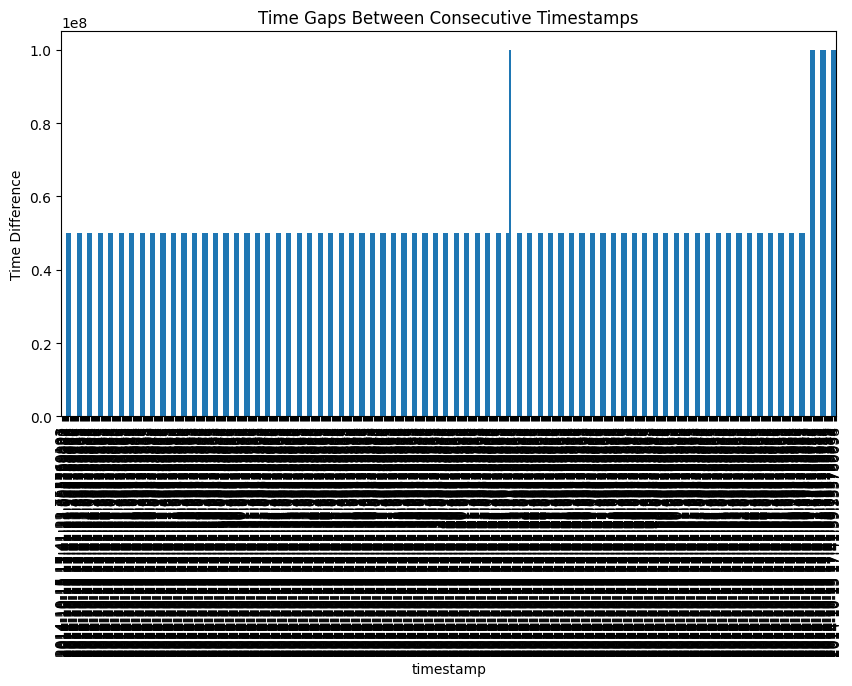

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\1408553103.py:3: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_input.resample('20L').mean()  # 'S' stands for second intervals


timestamp
2014-10-15 17:41:22.700                      NaT
2014-10-15 17:41:22.720   0 days 00:00:00.020000
2014-10-15 17:41:22.740   0 days 00:00:00.020000
2014-10-15 17:41:22.760   0 days 00:00:00.020000
2014-10-15 17:41:22.780   0 days 00:00:00.020000
                                   ...          
2014-10-15 17:41:59.260   0 days 00:00:00.020000
2014-10-15 17:41:59.280   0 days 00:00:00.020000
2014-10-15 17:41:59.300   0 days 00:00:00.020000
2014-10-15 17:41:59.320   0 days 00:00:00.020000
2014-10-15 17:41:59.340   0 days 00:00:00.020000
Freq: 20ms, Name: timestamp, Length: 1833, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.020000
Min difference: 0 days 00:00:00.020000
Mean difference: 0 days 00:00:00.020000
Median difference: 0 days 00:00:00.020000


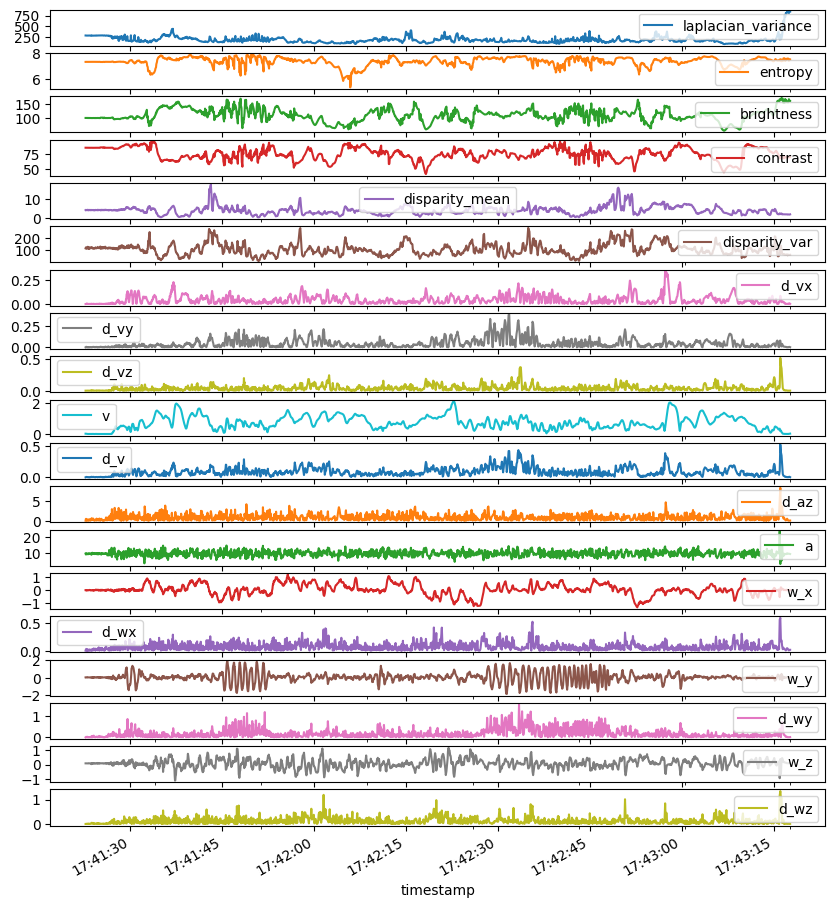

feature   laplacian_variance
laplacian_variance is not stationary, differencing...
feature   entropy
======== stationary =======
feature   brightness
======== stationary =======
feature   contrast
======== stationary =======
feature   disparity_mean
======== stationary =======
feature   disparity_var
======== stationary =======
feature   d_vx
======== stationary =======
feature   d_vy
======== stationary =======
feature   d_vz
======== stationary =======
feature   v
======== stationary =======
feature   d_v
======== stationary =======
feature   d_az
======== stationary =======
feature   a
======== stationary =======
feature   w_x
======== stationary =======
feature   d_wx
======== stationary =======
feature   w_y
======== stationary =======
feature   d_wy
======== stationary =======
feature   w_z
======== stationary =======
feature   d_wz
======== stationary =======
timestamp
2014-10-15 17:41:22.705760002                         NaT
2014-10-15 17:41:22.755760193   0 days 00:00:00.05000

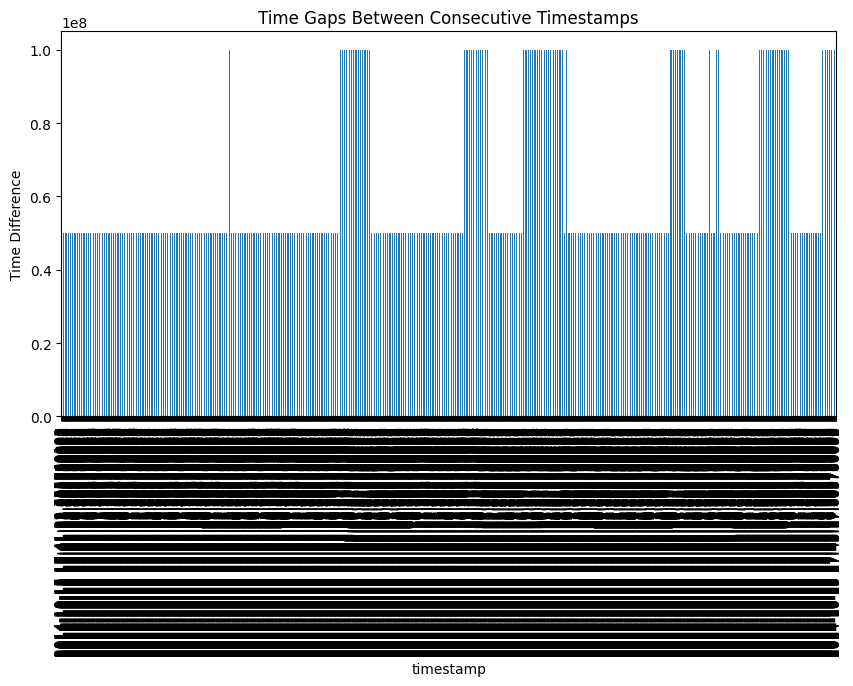

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\1408553103.py:3: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_input.resample('20L').mean()  # 'S' stands for second intervals


timestamp
2014-10-15 17:41:22.700                      NaT
2014-10-15 17:41:22.720   0 days 00:00:00.020000
2014-10-15 17:41:22.740   0 days 00:00:00.020000
2014-10-15 17:41:22.760   0 days 00:00:00.020000
2014-10-15 17:41:22.780   0 days 00:00:00.020000
                                   ...          
2014-10-15 17:43:17.620   0 days 00:00:00.020000
2014-10-15 17:43:17.640   0 days 00:00:00.020000
2014-10-15 17:43:17.660   0 days 00:00:00.020000
2014-10-15 17:43:17.680   0 days 00:00:00.020000
2014-10-15 17:43:17.700   0 days 00:00:00.020000
Freq: 20ms, Name: timestamp, Length: 5751, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.020000
Min difference: 0 days 00:00:00.020000
Mean difference: 0 days 00:00:00.020000
Median difference: 0 days 00:00:00.020000


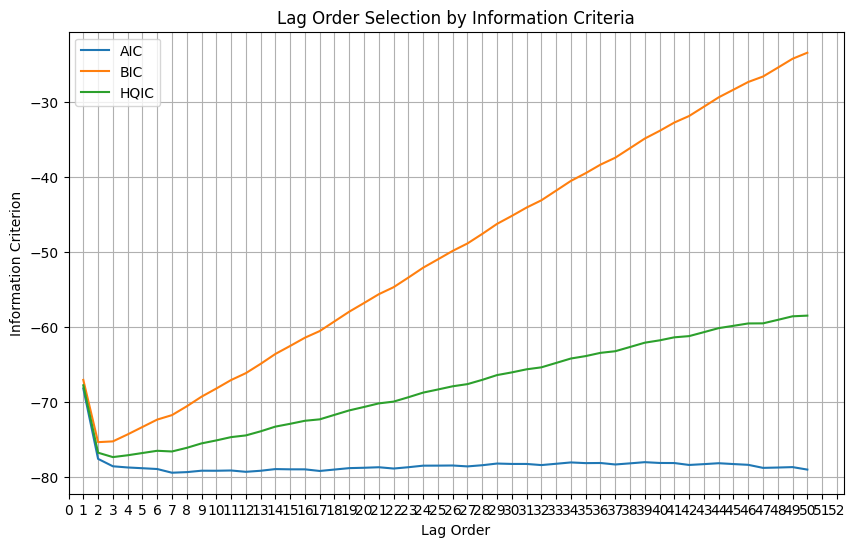

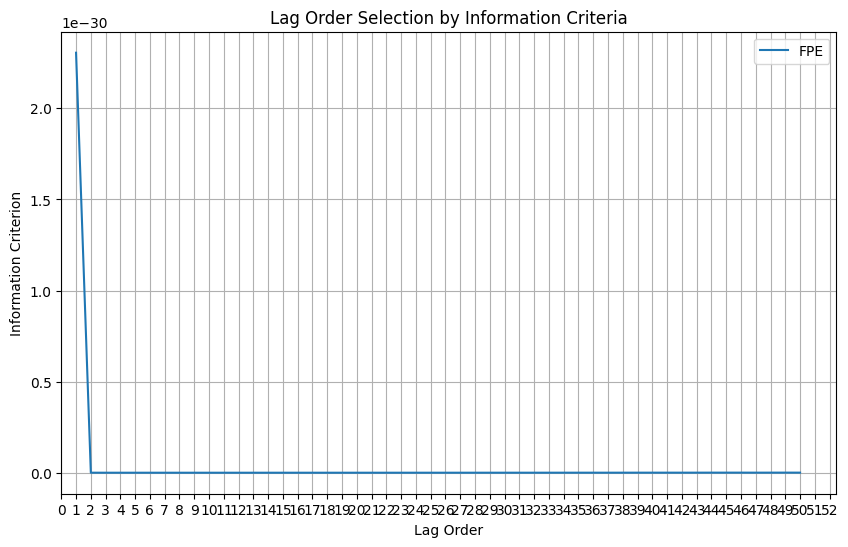

In [114]:
selected_features_1=['laplacian_variance', 'entropy', 'brightness', 'contrast','disparity_mean','disparity_var','d_vx','d_vy','d_vz','v','d_v','d_az','a','w_x','d_wx','w_y','d_wy','w_z','d_wz']
df_train_1,df_test_1,df_test_res_1=main_calculation(selected_features_1,True,'features_v203_openvslam_test.csv','features_v203_openvslam_train.csv')

In [153]:
df_train_1 = df_train_1[selected_features_1]
df_test_1 = df_test_1[selected_features_1]

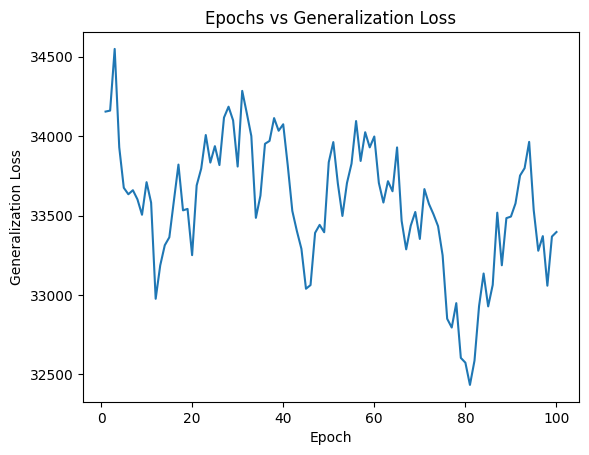

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\4143414291.py:10: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  axes[i].axvspan(j, j + pd.Timedelta(20, unit='L'), color='red', alpha=0.3)


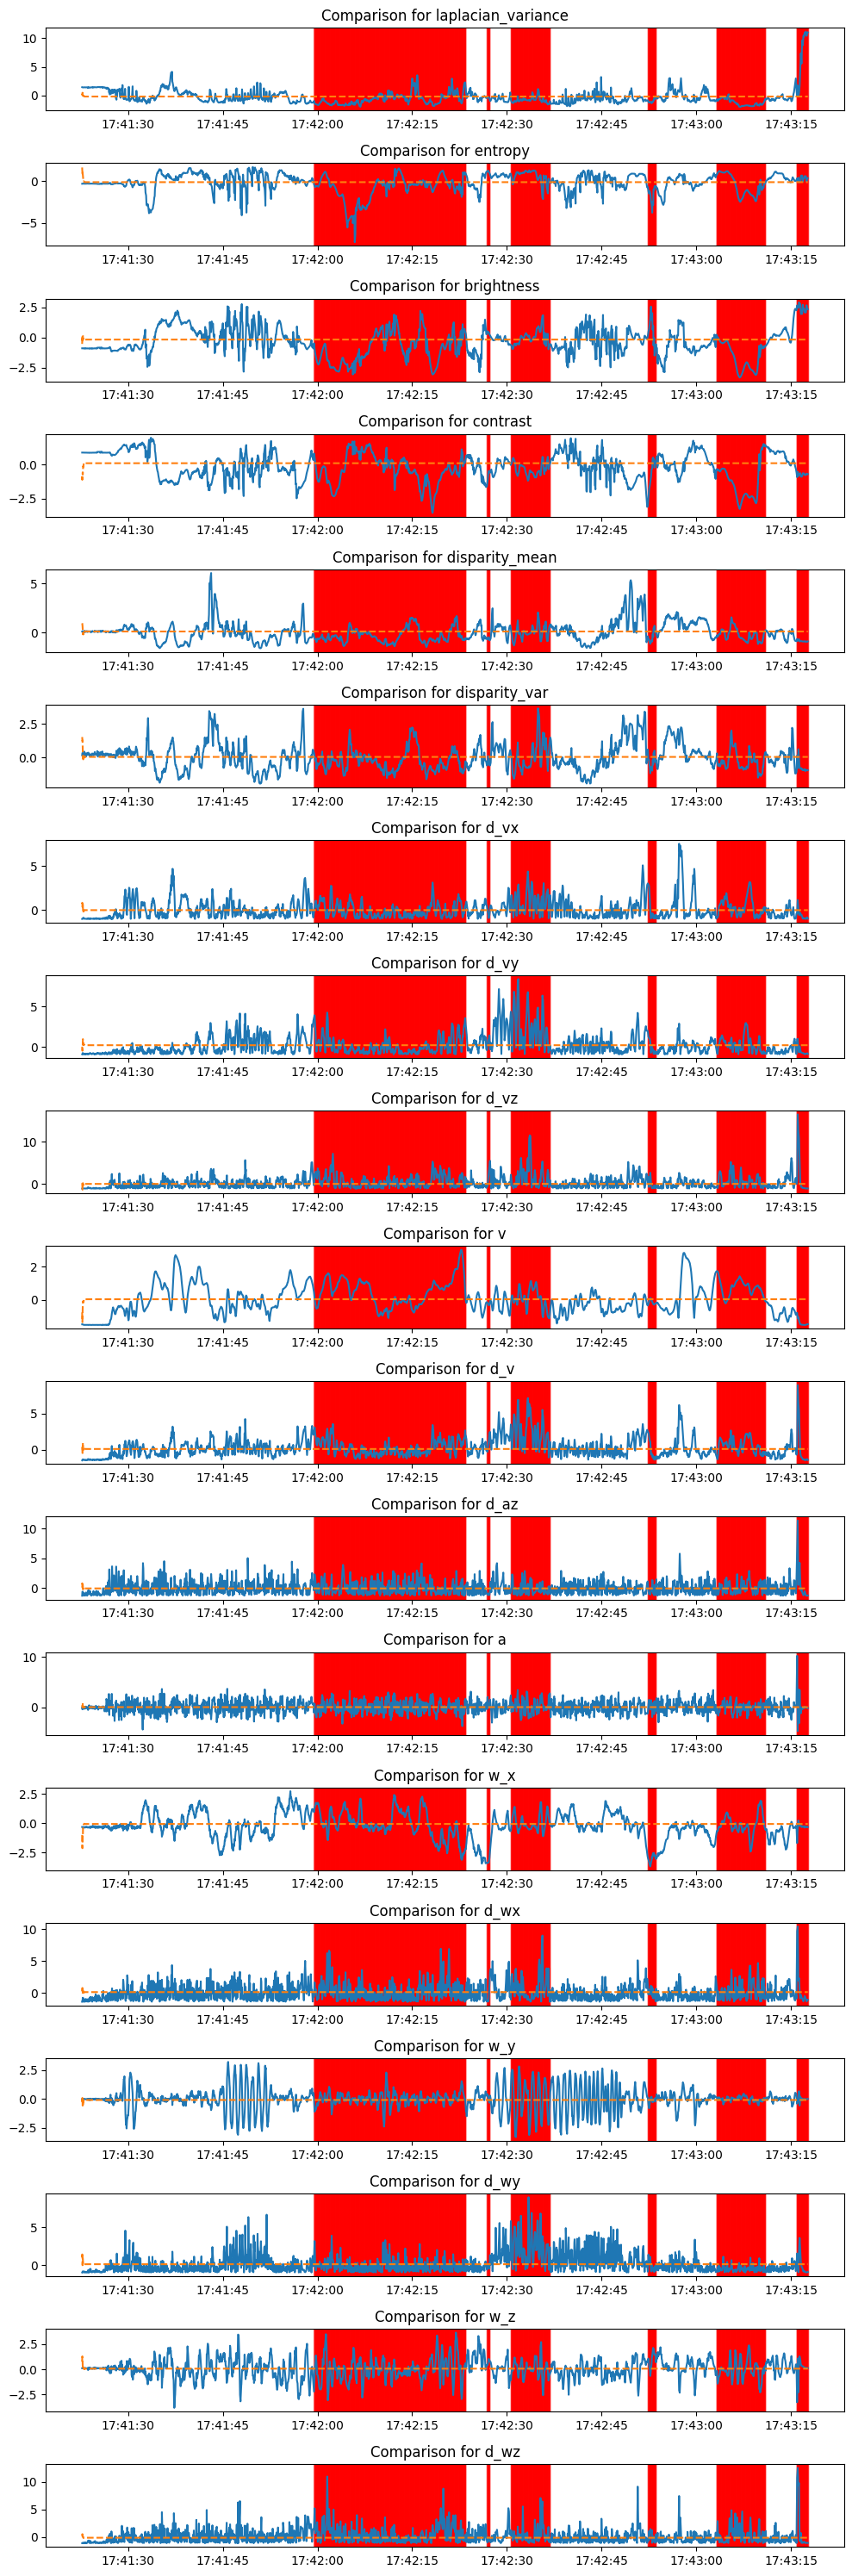

In [154]:
lag_1=7
num_epoch=100
trained_model_1=plot_epochs_vs_loss(df_train_1,lag_1,num_epoch)

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\4143414291.py:10: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  axes[i].axvspan(j, j + pd.Timedelta(20, unit='L'), color='red', alpha=0.3)


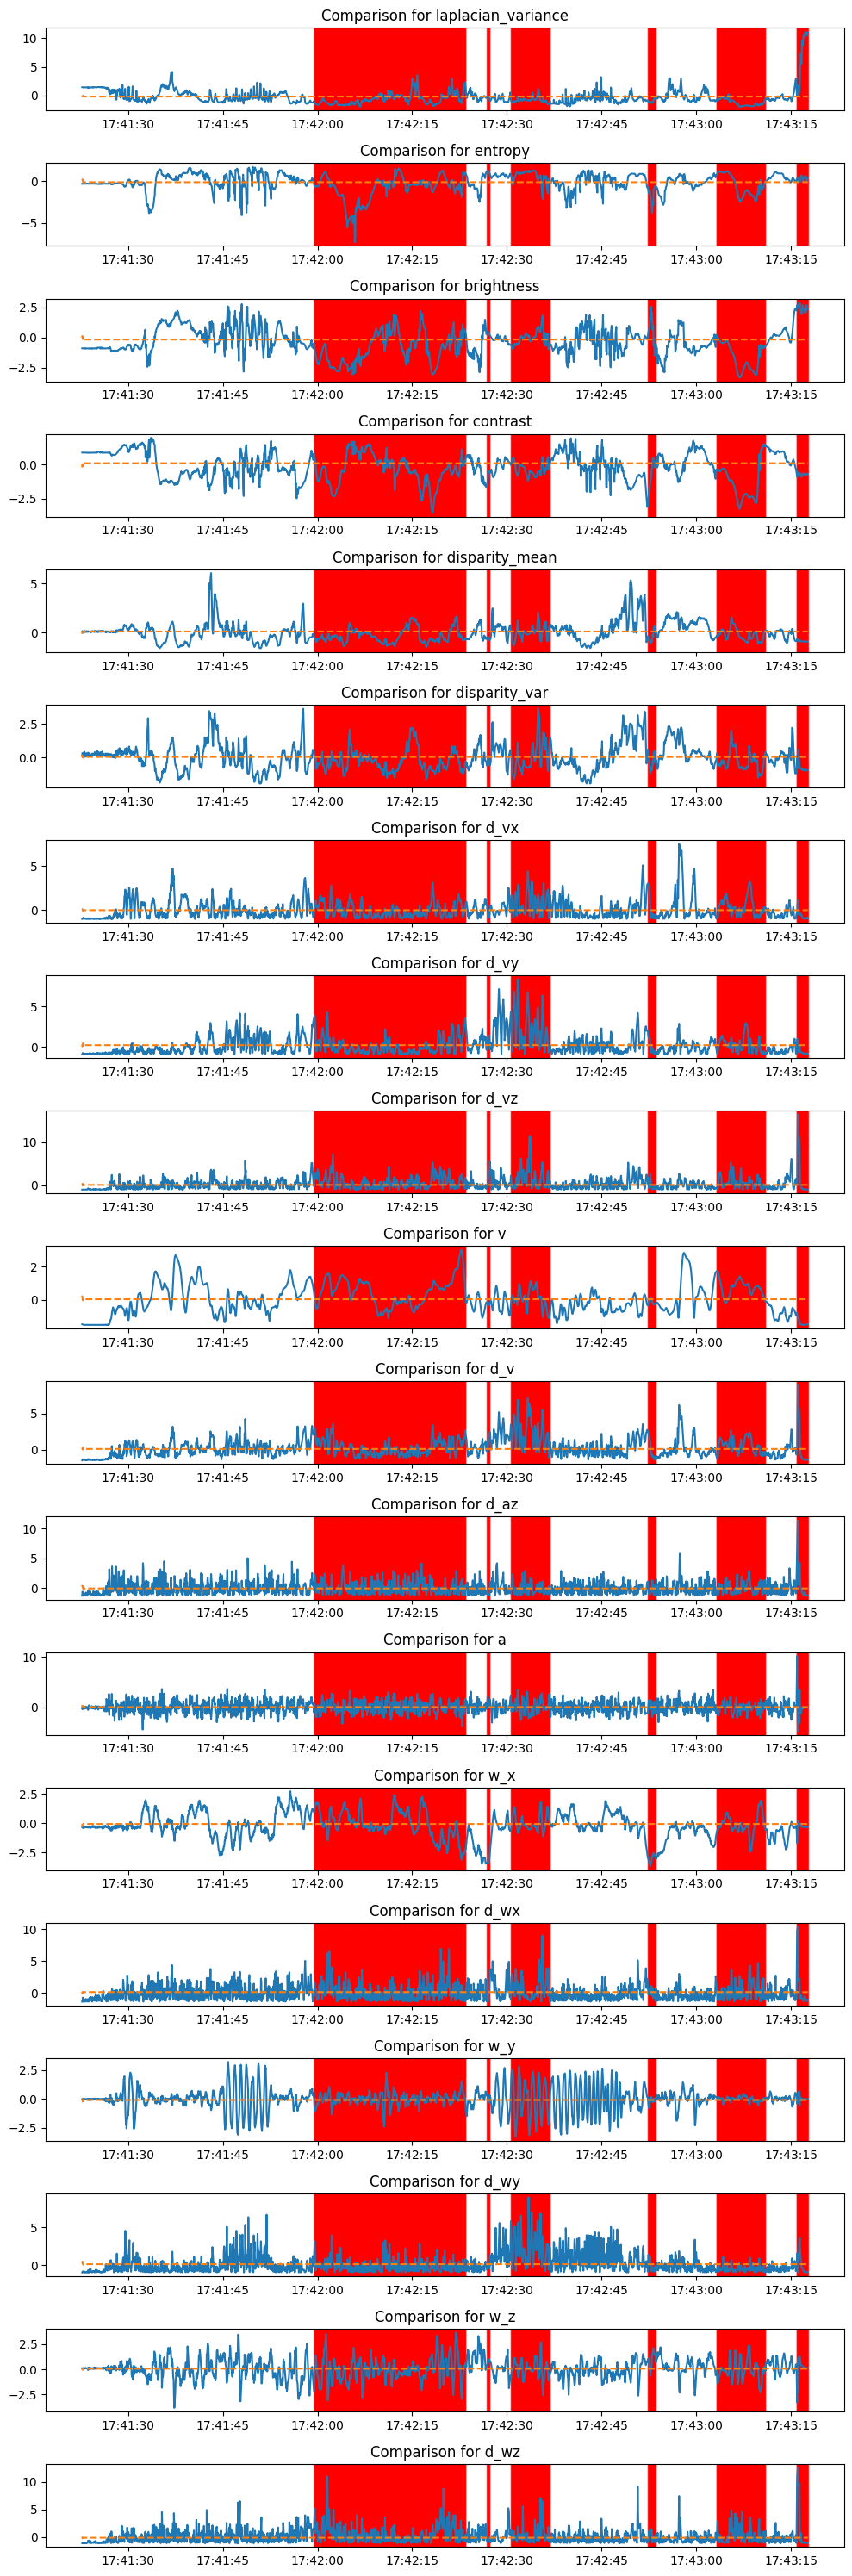

In [156]:
predicted_test_values_1 = predict_with_var_model(trained_model_1, lag_1, df_test_1)
plot_residual(selected_features_1,df_test_1,df_test_res_1,predicted_test_values_1)

In [105]:
with open('var_model.pkl', 'wb') as file:
    pickle.dump(trained_model_1, file)

Feature2

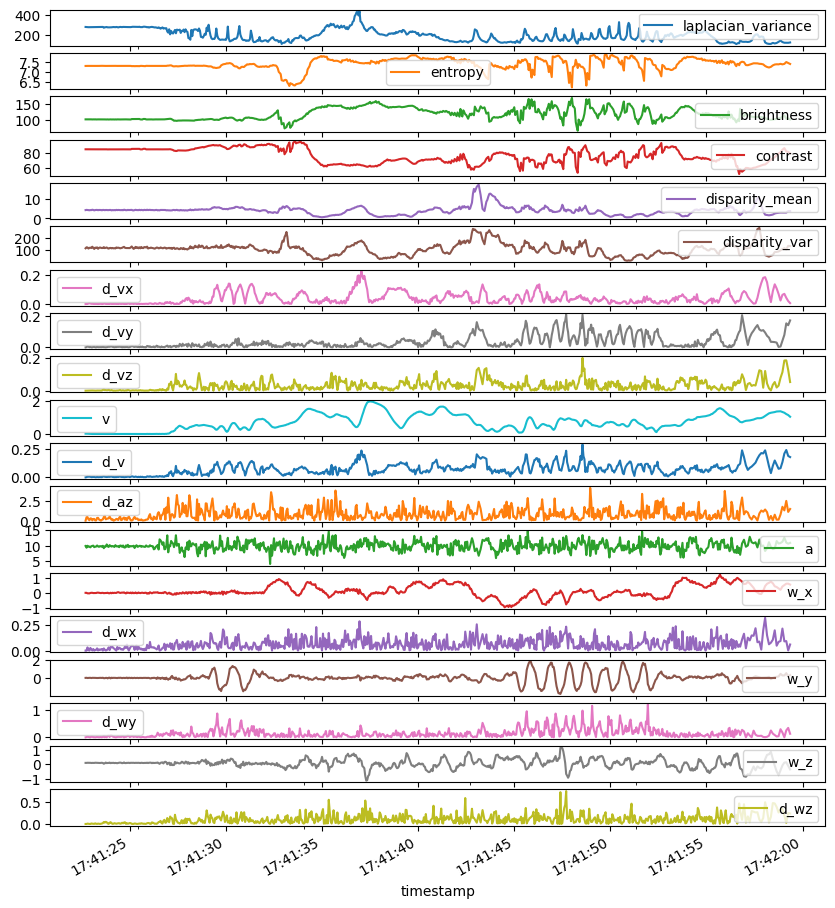

feature   laplacian_variance
laplacian_variance is not stationary, differencing...
feature   entropy
======== stationary =======
feature   brightness
brightness is not stationary, differencing...
feature   contrast
contrast is not stationary, differencing...
feature   disparity_mean
======== stationary =======
feature   disparity_var
======== stationary =======
feature   d_vx
======== stationary =======
feature   d_vy
d_vy is not stationary, differencing...
feature   d_vz
======== stationary =======
feature   v
======== stationary =======
feature   d_v
======== stationary =======
feature   d_az
======== stationary =======
feature   a
======== stationary =======
feature   w_x
w_x is not stationary, differencing...
feature   d_wx
======== stationary =======
feature   w_y
======== stationary =======
feature   d_wy
d_wy is not stationary, differencing...
feature   w_z
======== stationary =======
feature   d_wz
d_wz is not stationary, differencing...
timestamp
2014-10-15 17:41:22.705760002 

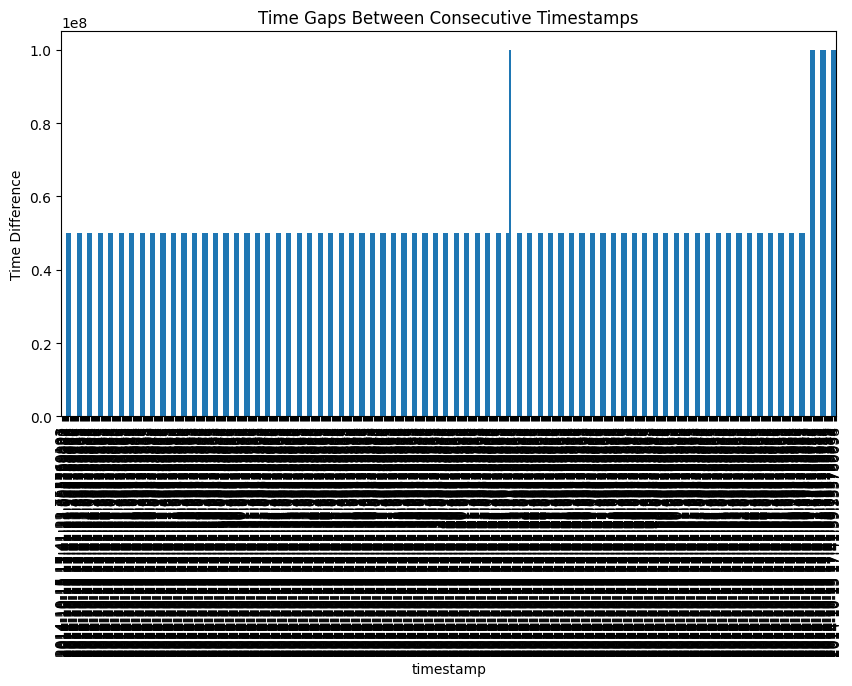

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\1408553103.py:3: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_input.resample('20L').mean()  # 'S' stands for second intervals


timestamp
2014-10-15 17:41:22.700                      NaT
2014-10-15 17:41:22.720   0 days 00:00:00.020000
2014-10-15 17:41:22.740   0 days 00:00:00.020000
2014-10-15 17:41:22.760   0 days 00:00:00.020000
2014-10-15 17:41:22.780   0 days 00:00:00.020000
                                   ...          
2014-10-15 17:41:59.260   0 days 00:00:00.020000
2014-10-15 17:41:59.280   0 days 00:00:00.020000
2014-10-15 17:41:59.300   0 days 00:00:00.020000
2014-10-15 17:41:59.320   0 days 00:00:00.020000
2014-10-15 17:41:59.340   0 days 00:00:00.020000
Freq: 20ms, Name: timestamp, Length: 1833, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.020000
Min difference: 0 days 00:00:00.020000
Mean difference: 0 days 00:00:00.020000
Median difference: 0 days 00:00:00.020000


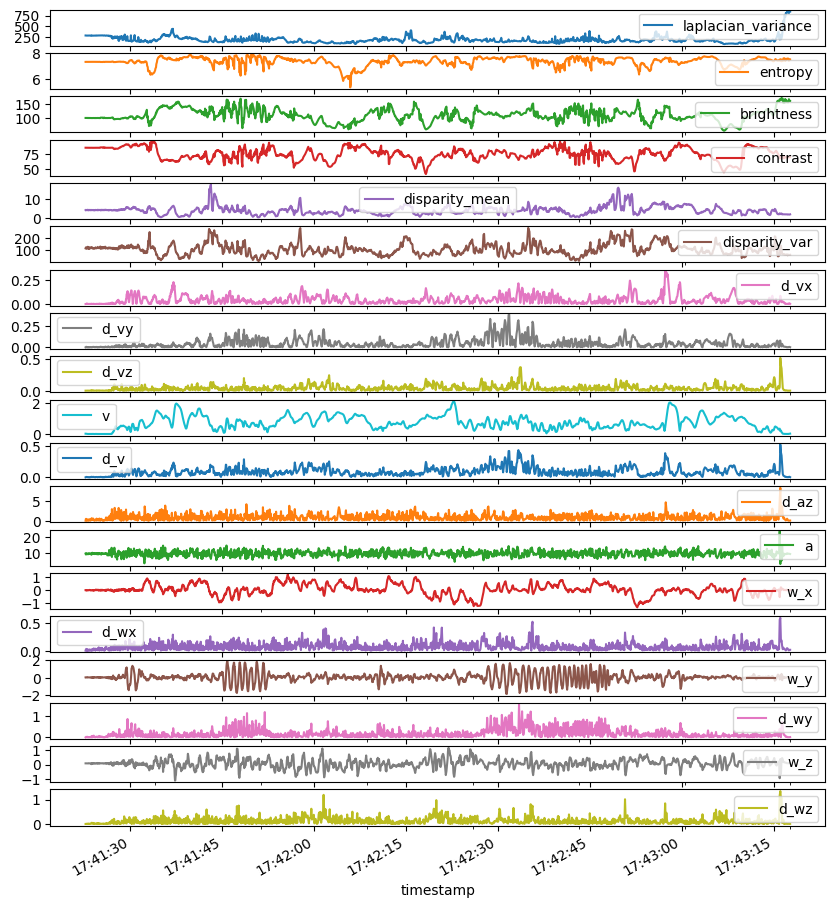

feature   laplacian_variance
laplacian_variance is not stationary, differencing...
feature   entropy
======== stationary =======
feature   brightness
======== stationary =======
feature   contrast
======== stationary =======
feature   disparity_mean
======== stationary =======
feature   disparity_var
======== stationary =======
feature   d_vx
======== stationary =======
feature   d_vy
======== stationary =======
feature   d_vz
======== stationary =======
feature   v
======== stationary =======
feature   d_v
======== stationary =======
feature   d_az
======== stationary =======
feature   a
======== stationary =======
feature   w_x
======== stationary =======
feature   d_wx
======== stationary =======
feature   w_y
======== stationary =======
feature   d_wy
======== stationary =======
feature   w_z
======== stationary =======
feature   d_wz
======== stationary =======
timestamp
2014-10-15 17:41:22.705760002                         NaT
2014-10-15 17:41:22.755760193   0 days 00:00:00.05000

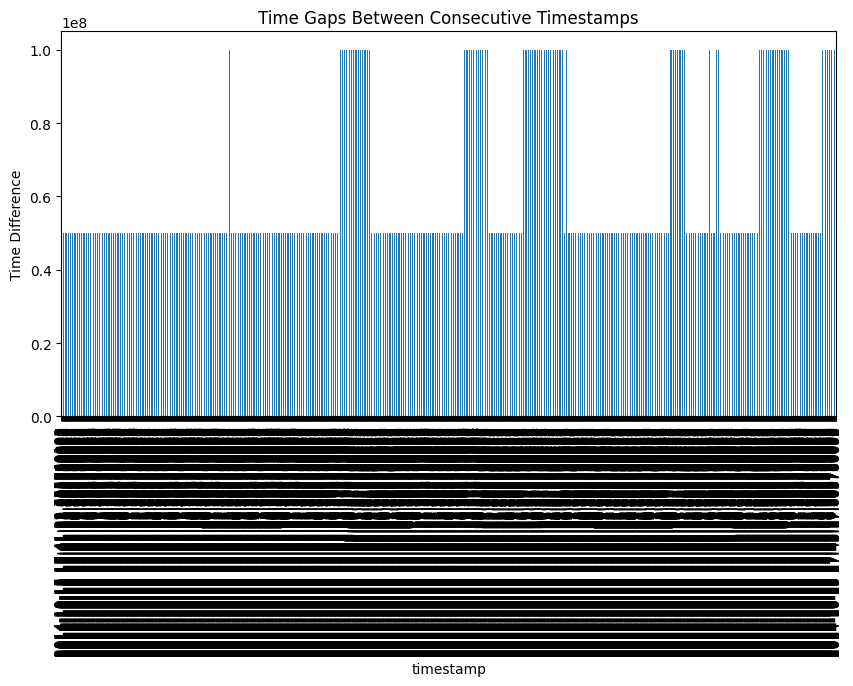

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\1408553103.py:3: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_input.resample('20L').mean()  # 'S' stands for second intervals


timestamp
2014-10-15 17:41:22.700                      NaT
2014-10-15 17:41:22.720   0 days 00:00:00.020000
2014-10-15 17:41:22.740   0 days 00:00:00.020000
2014-10-15 17:41:22.760   0 days 00:00:00.020000
2014-10-15 17:41:22.780   0 days 00:00:00.020000
                                   ...          
2014-10-15 17:43:17.620   0 days 00:00:00.020000
2014-10-15 17:43:17.640   0 days 00:00:00.020000
2014-10-15 17:43:17.660   0 days 00:00:00.020000
2014-10-15 17:43:17.680   0 days 00:00:00.020000
2014-10-15 17:43:17.700   0 days 00:00:00.020000
Freq: 20ms, Name: timestamp, Length: 5751, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.020000
Min difference: 0 days 00:00:00.020000
Mean difference: 0 days 00:00:00.020000
Median difference: 0 days 00:00:00.020000


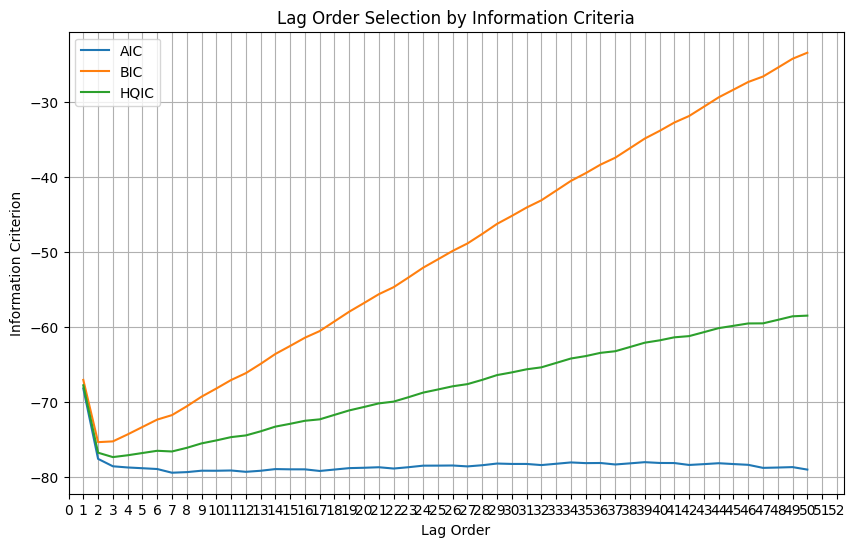

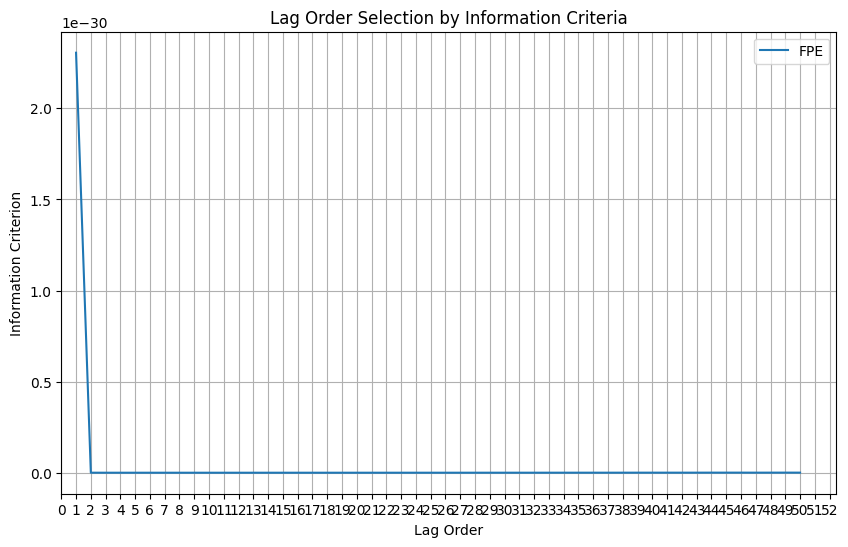

In [157]:
selected_features_2=['laplacian_variance', 'entropy', 'brightness', 'contrast','disparity_mean','disparity_var','d_vx','d_vy','d_vz','v','d_v','d_az','a','w_x','d_wx','w_y','d_wy','w_z','d_wz']
df_train_2,df_test_2,df_test_res_2=main_calculation(selected_features_2,True,'features_v203_openvslam_test.csv','features_v203_openvslam_train.csv')

In [158]:
df_train_2 = df_train_2[selected_features_2]
df_test_2 = df_test_2[selected_features_2]

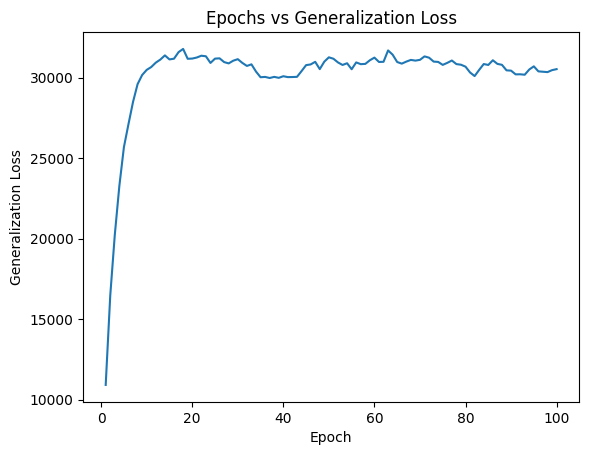

C:\Users\nrodw\AppData\Local\Temp\ipykernel_1672\4143414291.py:10: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  axes[i].axvspan(j, j + pd.Timedelta(20, unit='L'), color='red', alpha=0.3)


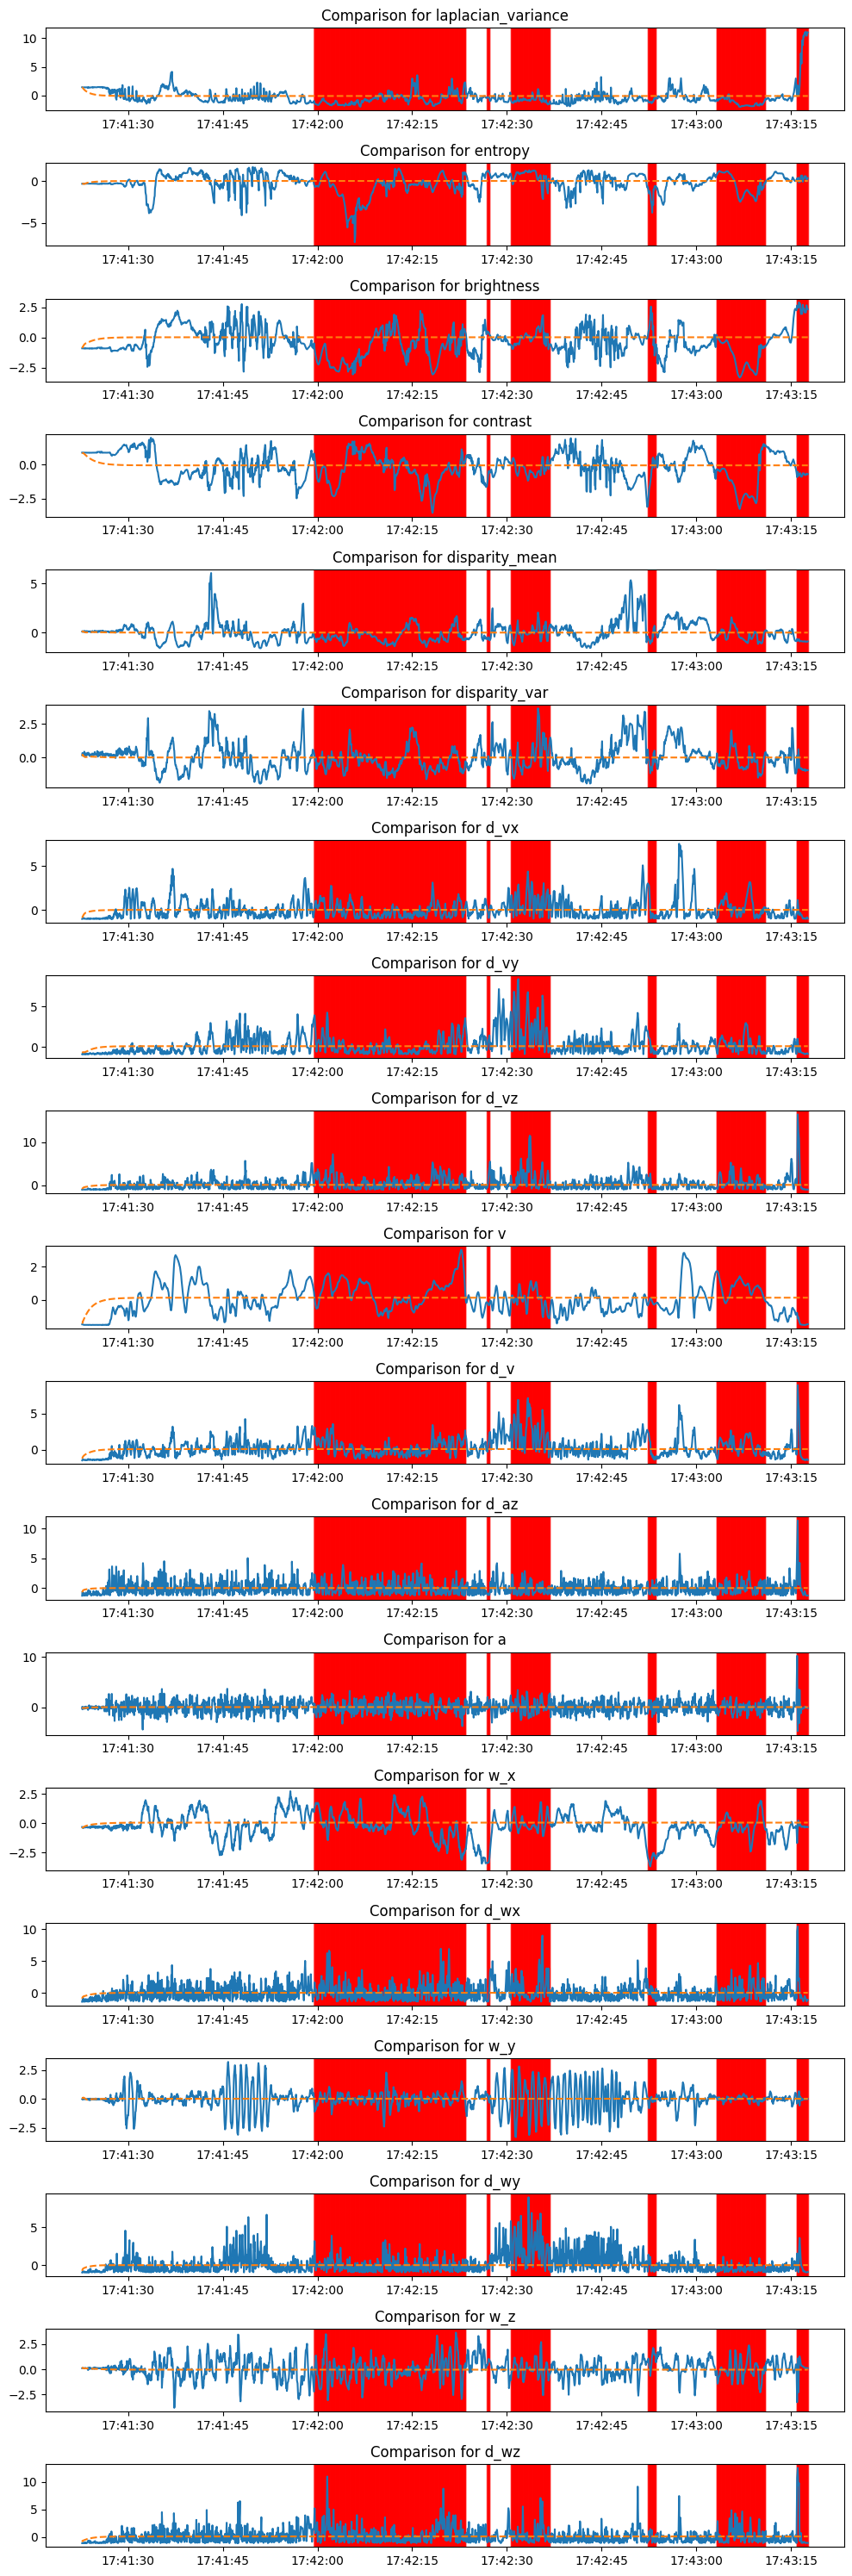

In [159]:
lag_2=7
num_epoch=100
trained_model_2=plot_epochs_vs_loss(df_train_2,lag_2,num_epoch)
predicted_test_values_2 = predict_with_var_model(trained_model_2, lag_2, df_test_2)
plot_residual(selected_features_2,df_test_2,df_test_res_2,predicted_test_values_2)

In [142]:
# Calculate the maximum, minimum, and mean values for each column
max_values = predicted_test_values_2.max()
min_values = predicted_test_values_2.min()
mean_values = predicted_test_values_2.mean()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Max': max_values,
    'Min': min_values,
    'Mean': mean_values
})

# Display the summary
print(summary_df)

                         Max       Min      Mean
laplacian_variance  0.015499 -0.515952 -0.510032
entropy             0.424707  0.291610  0.422455
brightness          0.014291 -0.295127  0.010135
contrast            0.505733  0.082249  0.089759
disparity_mean     -0.555620 -0.594055 -0.584835
disparity_var      -0.220304 -0.301671 -0.300614
d_vx               -0.634376 -0.937310 -0.637137
d_vy               -0.598771 -0.922542 -0.604275
d_vz               -0.657319 -0.961091 -0.660177
v                  -0.225291 -0.954895 -0.234800
d_v                -0.446448 -0.902921 -0.451718
d_az               -0.582103 -0.810331 -0.583350
a                   0.098648  0.054591  0.097970
w_x                 0.029069 -0.130188  0.025273
d_wx               -0.558863 -0.850375 -0.561908
w_y                 0.027913 -0.019258 -0.008013
d_wy               -0.743467 -0.935396 -0.745406
w_z                 0.077642  0.048792  0.049110
d_wz               -0.681280 -0.948188 -0.684353
row_max             